<a href="https://colab.research.google.com/drive/1JbMpw_nQaCq5WAZmY0iDWVEWWV4cgH9H?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificador de tejido sano y tejido cancerígeno en imagenes microscópicas del esófago

In [1]:
from IPython.display import Image

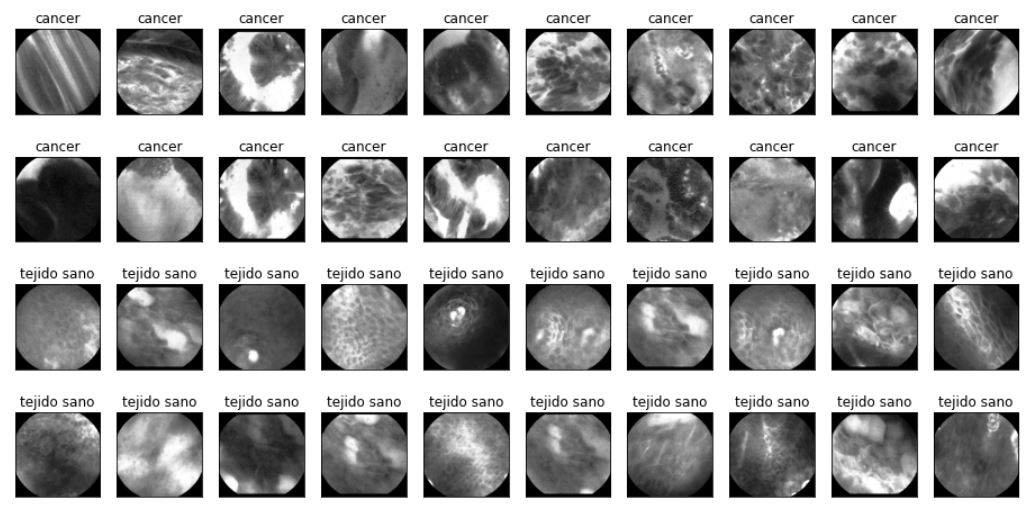

In [2]:
Image('https://raw.githubusercontent.com/contepablod/QCNNCancerClassifier/master/Esophagus%20Cancer.JPG')

## Paso 1. Cargar librerías y módulos requerdidos

In [3]:
import os            # módulo para manejar carpetas y archivos en nuestro ordenador
import random        # módulo para aleatorizar

import numpy as np   # biblioteca para manejar matrices y operaciones de matrices 
import pandas as pd  # biblioteca para manejar tablas de datos

#Skimage (Scikit-image): biblioteca para procesamiento de imágenes
from skimage import io  #Modulo para leer una imagen (librería para procesamiento de imagenes)

#Sklearn (Scikit-learn): biblioteca para machine learning 
from sklearn.model_selection import train_test_split   
from sklearn.linear_model import Perceptron 
from sklearn.metrics import accuracy_score

#Bibliotecas para gráficar y visualizar
import matplotlib.pyplot as plt        
import seaborn as sns

In [4]:
#Matriz de confusión
def matrix_confusion(yt, yp):
    data = {'Y_Real': yt,
            'Y_Prediccion': yp}

    df = pd.DataFrame(data, columns=['Y_Real','Y_Prediccion'])
    confusion_matrix = pd.crosstab(df['Y_Real'], df['Y_Prediccion'], rownames=['Real'], colnames=['Predicted'])
    sns.heatmap(confusion_matrix, annot=True, fmt='g')

    plt.show()

## Paso 2. Lectura de datos. 

### 2.1 Lectura de etiquetas (Y)

In [5]:
#Leemos los datos
datos = pd.read_csv("https://raw.githubusercontent.com/AnIsAsPe/ClassificadorCancerEsofago/master/Datos/ClasesImagenes.csv", usecols=[1,2])

In [6]:
datos.info()  #muestra los primeros cinco registros

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5063 entries, 0 to 5062
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_filename  5063 non-null   object
 1   class_number    5063 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 79.2+ KB


In [7]:
#¿cuántas imagenes tenemos de cada clase?
datos['class_number'].value_counts(sort=False)  

0    1469
1    3594
Name: class_number, dtype: int64

Clase 0 corresponde a tejido sano y Clase 1 a tejido Cancerígeno

In [8]:
Y = datos['class_number']  #Guardamos las etiquetas de las imagenes como serie de pandas

### 2.2 Lectura de imágenes (X)

In [9]:
datos['image_filename']

0          im_4_0.png
1         im_21_0.png
2          im_9_0.png
3          im_8_0.png
4         im_15_0.png
            ...      
5058    im_114_55.png
5059      im_7_55.png
5060     im_52_55.png
5061     im_10_55.png
5062    im_111_55.png
Name: image_filename, Length: 5063, dtype: object

## Puedes bajar las imagenes de:
https://github.com/contepablod/QCNNCancerClassifier/tree/master/CarpetaImagenes

En este caso las leeremos desde el disco

In [10]:
path = "C:\\Users\\conte\\OneDrive\\Escritorio\\Colegio Bourbaki\\ML-AI-WA\\Perceptron\\CarpetaImagenes\\"

In [11]:
%time  img = datos['image_filename'].apply(lambda x: io.imread(path + x, as_gray=True))

CPU times: total: 18.4 s
Wall time: 55.5 s


- Dimensión 0: 260 renglones de pixeles de arriba a abajo
- Dimensión 1: 260 columnas de pixeles de izquierda a derecha


####  Transformar imágenes en vectores
Lo primero es transformar la secuencia de matrices img en una sola matriz


In [12]:
img.shape

(5063,)

In [13]:
img[0].shape

(260, 260)

In [14]:
IMG = np.stack(img, axis=0)  # Toma una secuencia de matrices y las apila a lo largo 
                              # de un tercer eje para hacer una solo arreglo               
IMG.shape

(5063, 260, 260)

Despues aplanar la matriz de 2D (260x260 pixeles) de cada imagen, para obtener un vector por imagen. 

In [15]:
X = IMG.reshape(5063, -1) # se puede poner 67600 en vez de -1
X.shape

(5063, 67600)

##### Visualizamos ejemplos de ambas clases de imagenes

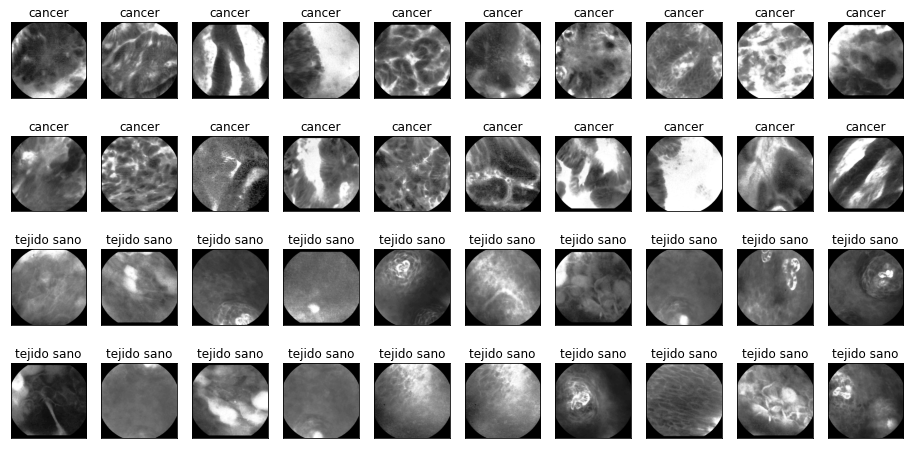

In [16]:
#El método GroupBy de Pandas separa un data frame en varios data frames
porClase = datos.groupby('class_number')


#elije al azar n muestras de cada subconjunto y guarda la posición de las figuras elegidas en una lista
n = 20
c = random.sample(porClase.get_group(1).index.tolist(), n) # indices de las imagenes cancerígenas seleccionadas
s = random.sample(porClase.get_group(0).index.tolist(), n) # indices de las imagenes sanas seleccionadas

# Grafica 20 imágenes aleatorias de tejido con cáncer y 20 de tejido sano

fig = plt.figure(figsize=(16, 8))
columns = 10
rows = 4
for i in range(0, columns * rows):
    fig.add_subplot(rows, columns, i+1)
    if i < 20:
        plt.imshow(img[c[i]], cmap='Greys_r')
        plt.title('cancer')
        plt.xticks([])
        plt.yticks([])
    else:
        plt.imshow(img[s[i-20]], cmap='Greys_r')
        plt.title('tejido sano')
        plt.xticks([])
        plt.yticks([])
plt.show()

## Paso 3. Entrenamiento utilizando perceptrón simple con conjunto de entrenamiento y prueba

### 3.1  Crear subconjuntos de entrenamiento y prueba



In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, 
                                                    shuffle=True, random_state=0) #random_state es el valor semilla

In [18]:
# ¿Cómo son los conjuntos de entrenamiento y prueba?
print("Training set")
print("X: ", X_train.shape)
print("Y: ", y_train.shape)
unique, counts = np.unique(y_train, return_counts=True)
print('Tejido Sano:        ', counts[0],'\nDisplasia o Cáncer: ', counts[1],'\n')


print("Test set")
print("X: ", X_test.shape)
print("Y: ", y_test.shape)
unique, counts = np.unique(y_test, return_counts=True)
print('Tejido Sano:         ', counts[0],'\nDisplasia o Cáncer: ', counts[1],'\n')

Training set
X:  (3544, 67600)
Y:  (3544,)
Tejido Sano:         1043 
Displasia o Cáncer:  2501 

Test set
X:  (1519, 67600)
Y:  (1519,)
Tejido Sano:          426 
Displasia o Cáncer:  1093 



### 3.2  Entrenamiento del Perceptrón

In [19]:
model_p = Perceptron(max_iter=50, random_state=0, verbose=True)
model_p.fit(X_train,y_train)             

-- Epoch 1
Norm: 1123.26, NNZs: 67600, Bias: -39.000000, T: 3544, Avg. loss: 1641.286726
Total training time: 0.52 seconds.
-- Epoch 2
Norm: 1709.08, NNZs: 67600, Bias: -56.000000, T: 7088, Avg. loss: 1415.700003
Total training time: 0.94 seconds.
-- Epoch 3
Norm: 2155.80, NNZs: 67600, Bias: -69.000000, T: 10632, Avg. loss: 1231.936834
Total training time: 1.36 seconds.
-- Epoch 4
Norm: 2616.13, NNZs: 67600, Bias: -76.000000, T: 14176, Avg. loss: 1124.851144
Total training time: 1.82 seconds.
-- Epoch 5
Norm: 3021.59, NNZs: 67600, Bias: -75.000000, T: 17720, Avg. loss: 1133.721658
Total training time: 2.27 seconds.
-- Epoch 6
Norm: 3379.11, NNZs: 67600, Bias: -74.000000, T: 21264, Avg. loss: 971.851823
Total training time: 2.68 seconds.
-- Epoch 7
Norm: 3724.07, NNZs: 67600, Bias: -66.000000, T: 24808, Avg. loss: 937.594908
Total training time: 3.10 seconds.
-- Epoch 8
Norm: 4026.70, NNZs: 67600, Bias: -68.000000, T: 28352, Avg. loss: 855.373414
Total training time: 3.49 seconds.
-- Ep

Perceptron(max_iter=50, verbose=True)

In [20]:
y_pred = model_p.predict(X_test)  #pasa cada una de las imágenes de X_test por el modelo 

In [21]:
print("Accuracy: %.2f%%" % (accuracy_score(y_test, y_pred)*100))

Accuracy: 90.19%


In [22]:
print("Precisión conjunto entrenamiento: %.2f%%" % (model_p.score(X_train, y_train)*100.0))
print("Precisión conjunto prueba: %.2f%%" % (model_p.score(X_test, y_test)*100.0))

Precisión conjunto entrenamiento: 95.49%
Precisión conjunto prueba: 90.19%


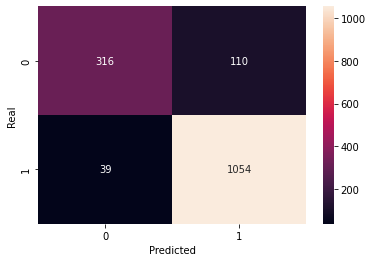

In [23]:
matrix_confusion(y_test, y_pred)

## Paso 4. Entrenamiento de perceptron utilizando margen

In [24]:
model_mp = Perceptron(max_iter=1000, random_state=0, verbose=False, alpha=0.0001) 
model_mp.fit(X_train,y_train)                                  

print("Precisión conjunto entrenamiento: %.2f%%" % (model_mp.score(X_train, y_train)*100.0))
print("Precisión conjunto prueba: %.2f%%" % (model_mp.score(X_test, y_test)*100.0))

Precisión conjunto entrenamiento: 95.49%
Precisión conjunto prueba: 90.19%


In [25]:
y_pred = model_mp.predict(X_test)  #pasa cada una de las imágenes de X_test por el modelo

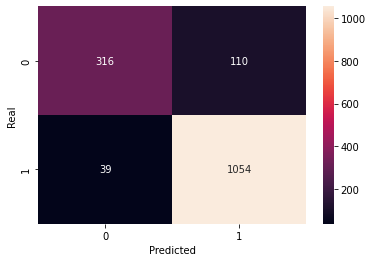

In [26]:
matrix_confusion(y_test, y_pred)

In [27]:
model_mp1 = Perceptron(max_iter=1000,  random_state=0, verbose=False, alpha=0.000001, penalty='l2') # Mas margen y con penalidad
model_mp1.fit(X_train,y_train) 

print("Precisión conjunto entrenamiento: %.2f%%" % (model_mp1.score(X_train, y_train)*100.0))
print("Precisión conjunto prueba: %.2f%%" % (model_mp1.score(X_test, y_test)*100.0))

Precisión conjunto entrenamiento: 98.59%
Precisión conjunto prueba: 92.03%


In [28]:
y_pred = model_mp1.predict(X_test)  #pasa cada una de las imágenes de X_test por el modelo

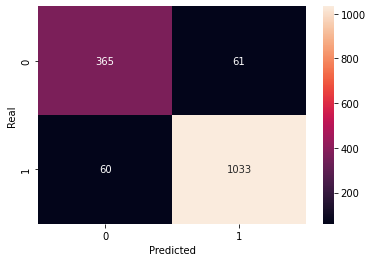

In [29]:
matrix_confusion(y_test, y_pred)

## Paso5. Entrenamiento QCNN usando Quantum Machine Learning


In [30]:
# Pytorch
import torch, torchvision, torch.utils
from torch import Tensor
from torch import cat
from torch.autograd.grad_mode import no_grad
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss, BCELoss, CrossEntropyLoss, MSELoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F
from torchviz import make_dot

# Qiskit
from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

## Puedes bajar las imagenes ya clasificadas de:
https://github.com/contepablod/QCNNCancerClassifier/tree/master/Imagenes

En este caso las leeremos desde el disco

In [31]:
train_data = torchvision.datasets.ImageFolder('C:\\Users\\conte\\OneDrive\\Escritorio\\Colegio Bourbaki\\ML-AI-WA\\Perceptron\\Imagenes_Clasificadas_Random_Split\\Train', transform=transforms.Compose([transforms.ToTensor()]))
test_data = torchvision.datasets.ImageFolder('C:\\Users\\conte\\OneDrive\\Escritorio\\Colegio Bourbaki\\ML-AI-WA\\Perceptron\\Imagenes_Clasificadas_Random_Split\\Test', transform=transforms.Compose([transforms.ToTensor()]))

Dimensión del Tensor

In [32]:
train_data[0][0].shape

torch.Size([3, 260, 260])

In [33]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=1)
test_loader = DataLoader(test_data, shuffle=True, batch_size=1)

## Mostramos las imágemenes

In [34]:
# False significa que no hay cancer (0) y True que sí (1)
print((train_loader.dataset.class_to_idx))

{'False': 0, 'True': 1}


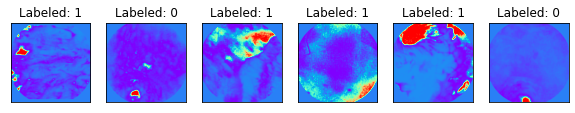

In [35]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 10))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap=plt.cm.rainbow)
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title(f"Labeled: {targets[0].item()}")

    n_samples_show -= 1

## Cómo funciona una red neuronal híbrida

In [36]:
Image(url='https://raw.githubusercontent.com/contepablod/QCNNCancerClassifier/master/hybridnetwork.png') 

### Declaramos circuito cuántico a través de un terra back-end

In [37]:
# Declaramos Instancia Cuantica
qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))

## Cómo interactua el circuito cuántico con la red neuronal convolucional

In [38]:
Image(url='https://raw.githubusercontent.com/contepablod/QCNNCancerClassifier/master/neuralnetworkQC.png') 

### Definimos la Red Neuronal Cuántica

In [39]:
# Define and create QNN
def create_qnn():
    feature_map = ZZFeatureMap(2)
    ansatz = RealAmplitudes(2, reps=1)
    # input_gradients=True para gradiente híbrido
    qnn = TwoLayerQNN(
        2, #numero de Qubits, solo son posibles dos estados
        feature_map,
        ansatz,
        input_gradients=True,
        exp_val=AerPauliExpectation(),
        quantum_instance=qi,
    )
    return qnn


qnn = create_qnn()
print(qnn.operator)

ComposedOp([
  OperatorMeasurement(1.0 * ZZ),
  CircuitStateFn(
       ┌──────────────────────────┐┌──────────────────────────────────────┐
  q_0: ┤0                         ├┤0                                     ├
       │  ZZFeatureMap(x[0],x[1]) ││  RealAmplitudes(θ[0],θ[1],θ[2],θ[3]) │
  q_1: ┤1                         ├┤1                                     ├
       └──────────────────────────┘└──────────────────────────────────────┘
  )
])


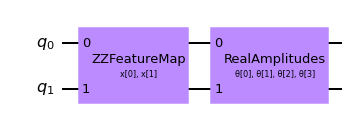

In [40]:
qnn.circuit.draw(output='mpl')

### Definimos la red Neuronal en Pytorch

In [41]:
# Red Neuronal en Pytorch
class Net(Module):
    def __init__(self, qnn):
        super().__init__()
        self.conv1 = Conv2d(3, 128, kernel_size=5)
        self.conv2 = Conv2d(128, 128, kernel_size=3)
        self.dropout = Dropout2d()
        self.fc1 = Linear(508032, 128)
        self.fc2 = Linear(128, 2)  # Input bidimensional para la red neuronal cuántica
        self.qnn = TorchConnector(qnn) # Aplicamos el conector Pytorch para conectar la red neuronal y el circuito
        # uniformly at random from interval [-1,1].
        self.fc3 = Linear(1, 1)  # Salida unidimensional del circuito cuántico

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # Aplicamos la red cuántica nuevamente en la sección forward
        x = self.fc3(x)
        return cat((x, 1 - x), -1)

model = Net(qnn)

### Activamos el GPU

In [42]:
model = model.to('cuda')

### Mostramos el modelo

In [43]:
print(model)

Net(
  (conv1): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=508032, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (qnn): TorchConnector()
  (fc3): Linear(in_features=1, out_features=1, bias=True)
)


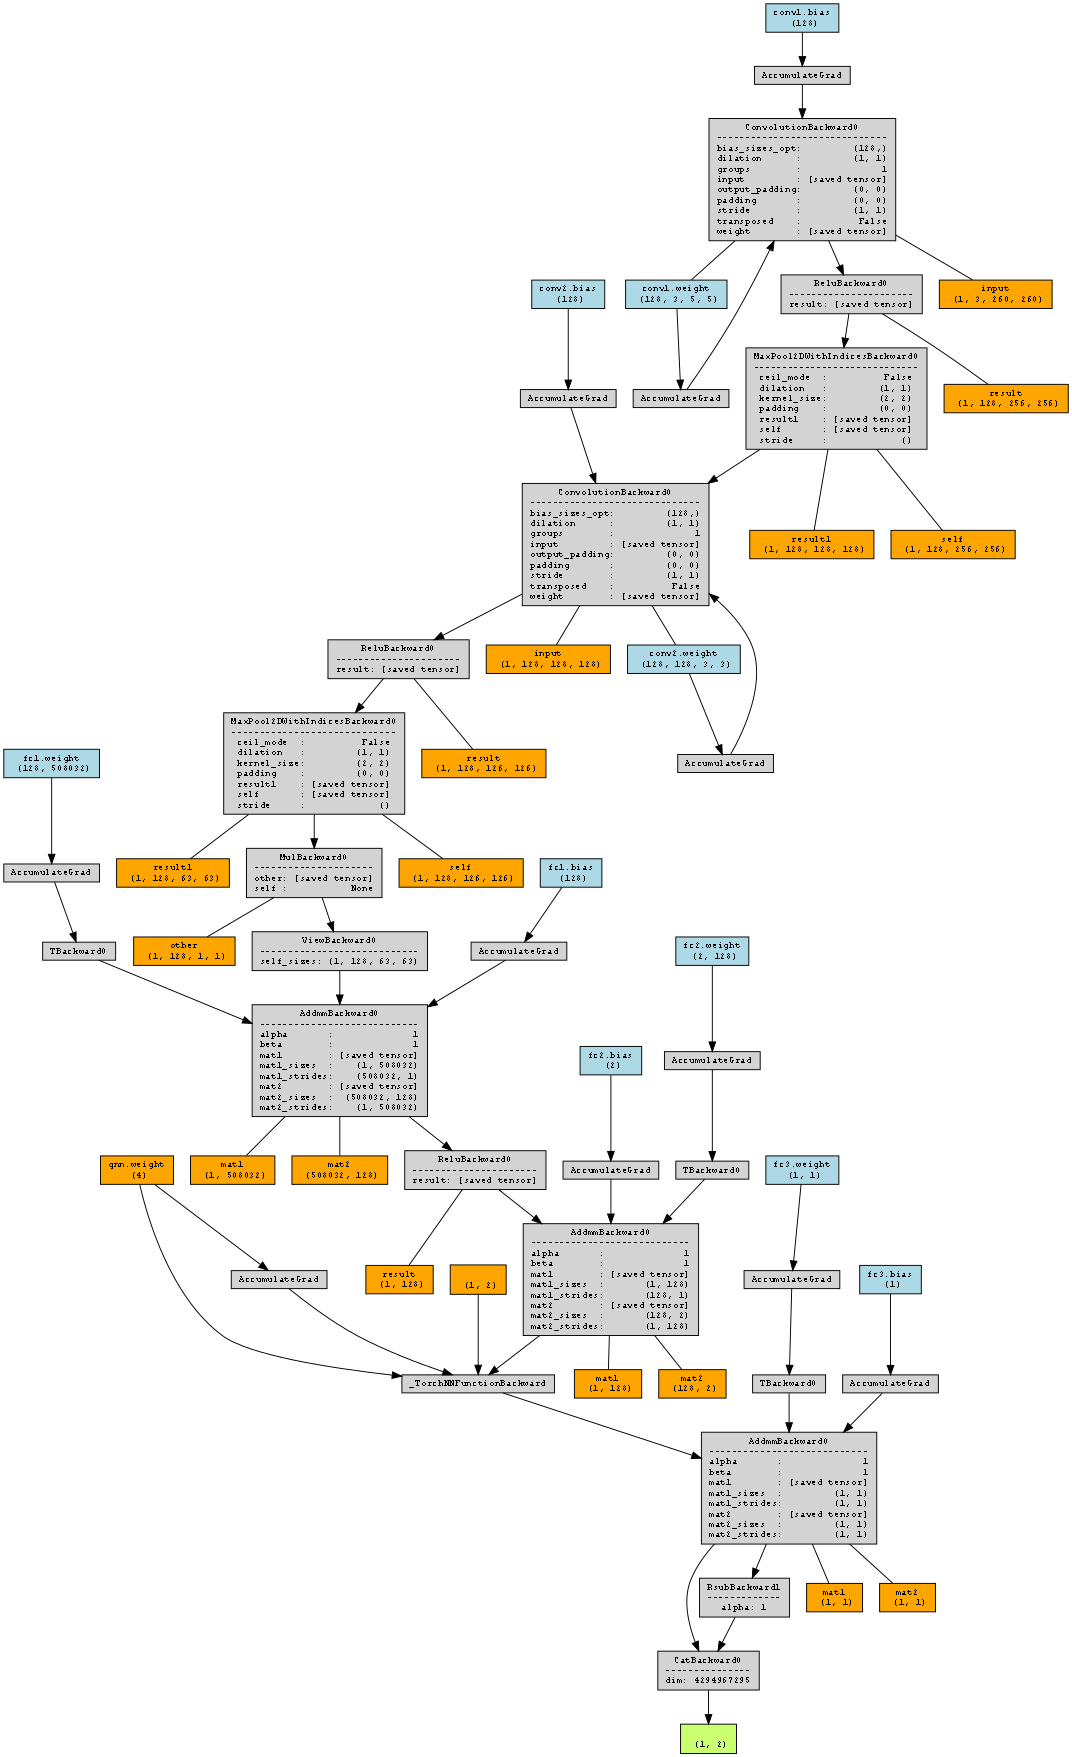

In [44]:
dummy_tensor = next(iter(train_loader))[0].to('cuda')
make_dot(model(dummy_tensor), params=dict(list(model.named_parameters())), show_saved=True, show_attrs=True).render("rnn_torchviz", format="png")
#Image('https://raw.githubusercontent.com/contepablod/QCNNCancerClassifier/master/rnn_torchviz.png') 
Image(r'C:\Users\conte\OneDrive\Escritorio\qiskit-fall-fest-peru-2022-main\qiskit-community-tutorials-master\qiskit-community-tutorials-master\drafts\rnn_torchviz.png')

### Definimos optimización, función de pérdida y entrenamos el modelo

In [45]:
# Definimos optimizador y función de pérdida
optimizer = optim.Adam(model.parameters(), lr=0.00001)
loss_func = CrossEntropyLoss().to('cuda')

# Empezamos entrenamiento
epochs = 50  # Número de épocas
model.train() # Modelo en modo entrenamiento

loss_list = []  
total_accuracy = []

for epoch in range(epochs):
    correct = 0
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Se inicializa gradiente
        output = model(data.to('cuda'))  # Forward pass, Datos a GPU
        loss = loss_func(output, target.to('cuda')) #Etiquetas a GPU
        loss.backward()  # Backward pass
        optimizer.step()  # Optimizamos pesos
        total_loss.append(loss.item())  # Cálculo de la función de pérdida
        train_pred = output.argmax(dim=1, keepdim=True)
        correct += train_pred.eq(target.to('cuda').view_as(train_pred)).sum().item()
    loss_list.append(sum(total_loss) / len(total_loss))
    accuracy = 100 * correct / len(train_loader) #Cálculo de precisión
    total_accuracy.append(accuracy) 
    print(f"Training [{100.0 * (epoch + 1) / epochs:.0f}%]\tLoss: {loss_list[-1]:.4f}\tAccuracy: {accuracy:.2f}%")

Training [2%]	Loss: 0.6617	Accuracy: 70.98%
Training [4%]	Loss: 0.6531	Accuracy: 70.98%
Training [6%]	Loss: 0.6433	Accuracy: 70.98%
Training [8%]	Loss: 0.6334	Accuracy: 70.98%
Training [10%]	Loss: 0.6224	Accuracy: 70.98%
Training [12%]	Loss: 0.6105	Accuracy: 70.98%
Training [14%]	Loss: 0.5964	Accuracy: 70.98%
Training [16%]	Loss: 0.5830	Accuracy: 70.98%
Training [18%]	Loss: 0.5697	Accuracy: 70.98%
Training [20%]	Loss: 0.5545	Accuracy: 70.98%
Training [22%]	Loss: 0.5394	Accuracy: 70.98%
Training [24%]	Loss: 0.5241	Accuracy: 70.98%
Training [26%]	Loss: 0.5077	Accuracy: 70.98%
Training [28%]	Loss: 0.4920	Accuracy: 70.98%
Training [30%]	Loss: 0.4766	Accuracy: 70.98%
Training [32%]	Loss: 0.4621	Accuracy: 70.98%
Training [34%]	Loss: 0.4455	Accuracy: 70.98%
Training [36%]	Loss: 0.4297	Accuracy: 70.98%
Training [38%]	Loss: 0.4127	Accuracy: 70.98%
Training [40%]	Loss: 0.3988	Accuracy: 70.98%
Training [42%]	Loss: 0.3841	Accuracy: 70.98%
Training [44%]	Loss: 0.3700	Accuracy: 70.98%
Training [46%]

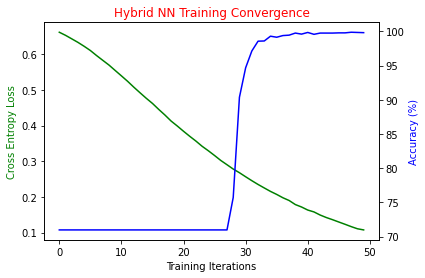

In [58]:
# Grafico de Convergencia de la función de pérdida y precisión
fig, ax1 = plt.subplots()
ax1.plot(loss_list, 'g-')
ax2 = ax1.twinx()
ax2.plot(total_accuracy, 'b')
plt.title("Hybrid NN Training Convergence", color='red')
ax1.set_xlabel("Training Iterations")
ax1.set_ylabel("Cross Entropy Loss", color='g')
ax2.set_ylabel("Accuracy (%)", color='b')
plt.show()

In [47]:
torch.save(model.state_dict(), "model.pt")

In [48]:
qnn1 = create_qnn()
model1 = Net(qnn1)
model1.load_state_dict(torch.load("model.pt"))
model1= model1.to('cuda')

In [78]:
batch_size=1

model1.eval()  # Evaluación del Modelo
pred_targets = []
test_targets= []
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model1(data.to('cuda'))
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        pred_targets.append(pred.item())
        test_targets.append(target.item())
        correct += pred.eq(target.to('cuda').view_as(pred)).sum().item()

        loss = loss_func(output, target.to('cuda'))
        total_loss.append(loss.item())

    print(
        "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(test_loader) / batch_size * 100
        )
    )

Performance on test data:
	Loss: 0.1144
	Accuracy: 98.8%


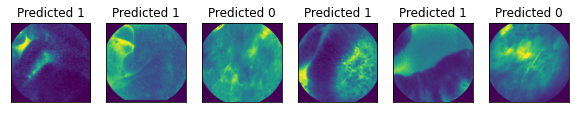

In [50]:
# Ploteo de Imagenes Predichas
from PIL import Image

n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model1.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model1(data.to('cuda')[0:1])
        if len(output.shape) == 1:
            output = output.reshape(3, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(torchvision.transforms.ToPILImage(mode='RGB')(data[0].squeeze()), cmap=plt.cm.rainbow)

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {}".format(pred.item()))

        count += 1

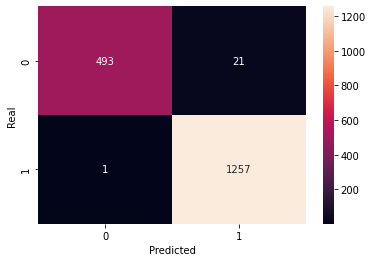

In [79]:
matrix_confusion(test_targets, pred_targets)

# Observaciones

- La red neuronal híbrida tiene mayor precisión que el perceptrón. 
- Recordemos que la entrada al perceptrón es una matriz que representa a las imagenes en escala de grises mientras que la entrada la red neuronal es un tensor [3, 260, 260]
- El Perceptrón al vectorizar la imagen pierde información sobre la misma, aunque se pueda reconstruir. La red neuronal trabaja con la información completa de la imágen
- Puede optimizarse hiperparámetros y arquitectura de la red neuronal híbrida
- No hay entrelazamiento cuántico en el circuito. 
- Se podría mejorar el circuito cuántico con mas cápas

# Referencias

1. Hybrid quantum-classical Neural Networks with PyTorch and Qiskit: https://qiskit.org/textbook/ch-machine-learning/machine-learning-qiskit-pytorch.html

2. Torch Connector and Hybrid QNNs: https://qiskit.org/documentation/machine-learning/tutorials/05_torch_connector.html

3. Clasificador de Cáncer de Esófago: https://github.com/AnIsAsPe/ClassificadorCancerEsofago

4. Clases Teóricas Colegio Bourbaki, Mexico
- https://www.colegio-bourbaki.com/
- LinkedIn: Colegio Bourbaki